In [1]:
##################################################################
############# FORECASTING DAY AHEAD ENERGY PRICE ################
################################################################

In [32]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from datetime import datetime as dt
import custom_module as cm

In [33]:
# Loading the dataset
data = pd.read_csv("combined_energy.csv", parse_dates=True)

In [34]:
##################################################################
##################### DATA PREPROCESSING ########################
################################################################

In [35]:
# Setting the format of dataset #

# Converting date to datetime object
data["SETTLEMENTDATE"] = pd.to_datetime(data["SETTLEMENTDATE"])

# Seperating data for each region
dataSA = data[data["REGIONID"] == "SA1"]

# Setting Index to Date
dataSA = dataSA[["SETTLEMENTDATE","RRP5min"]]
dataSA.index = dataSA["SETTLEMENTDATE"]
dataSA.drop(columns="SETTLEMENTDATE", inplace=True)

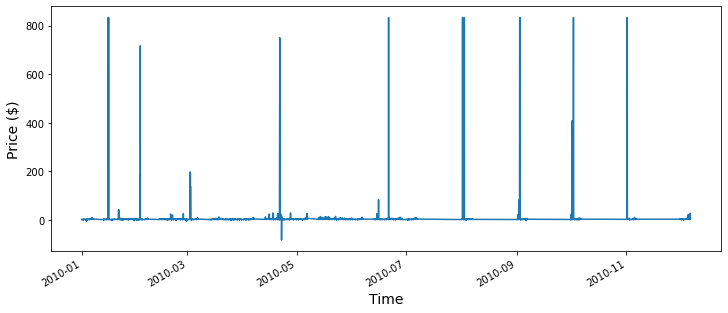

In [36]:
# plot the price 2010 data set
cm.plot_chart(dataSA.loc['2010'], title=None, legend=False)

In [37]:
# replace outliers by outlier threshold
dataSA = cm.replace_outliers(dataSA, 'RRP5min', 3)

In [7]:
# Convert Data into NP-Array
training_set = dataSA.loc[:'2009']
training_set = np.array(training_set.iloc[:,0:1].values)


In [8]:
# Scaling the training set between 0 and 1 as required by the NN
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(training_set)

In [9]:
# Creating a data structure with 288 timesteps and 1 output
# We will make use of 288 time lags, 5 mins each, to predict the next price
X_train = []
y_train = []
for i in range(288, 158112):
    X_train.append(training_set_scaled[i-288:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [31]:
training_set_scaled[1:289]

array([[0.50964783],
       [0.50964783],
       [0.50964783],
       [0.50964783],
       [0.50964783],
       [0.50342196],
       [0.49730389],
       [0.49727374],
       [0.48846706],
       [0.46557719],
       [0.4807645 ],
       [0.49022874],
       [0.50457767],
       [0.50837696],
       [0.49463144],
       [0.50096767],
       [0.50648513],
       [0.46610659],
       [0.49403774],
       [0.5017442 ],
       [0.45492508],
       [0.49580877],
       [0.45490728],
       [0.45357465],
       [0.46251148],
       [0.46853418],
       [0.42783495],
       [0.41981797],
       [0.39670395],
       [0.39541363],
       [0.38532527],
       [0.38484373],
       [0.3624878 ],
       [0.3664937 ],
       [0.36723617],
       [0.36686553],
       [0.36625329],
       [0.36900049],
       [0.37559874],
       [0.36434067],
       [0.36672303],
       [0.36681612],
       [0.36530157],
       [0.36464574],
       [0.36256073],
       [0.36036628],
       [0.36050224],
       [0.363

In [30]:
scaler.transform(test_set)

array([[0.42168764],
       [0.42982787],
       [0.42841767],
       ...,
       [0.41435473],
       [0.41169273],
       [0.37424421]])

In [10]:
# RNN Expects a 3D array so reshaping
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [11]:
#########################################################################
##################### DEEP LEARNING TRAIN MODEL ########################
#######################################################################

In [12]:
from keras.models import Model, load_model
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [13]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [170]:
###################### DESIGNING THE NN ###################
##########################################################

# Initialising
rnn = Sequential()
# Adding Conv1D Layer
rnn.add(Conv1D(64, kernel_size=288, strides=288, padding='valid', input_shape=(X_train.shape[1],1)))
# Add LSTM layer 1st
rnn.add(LSTM(50, recurrent_activation='relu', return_sequences=True))
rnn.add(Dropout(0.1))
# Add LSTM layer 2nd
rnn.add(LSTM(50, recurrent_activation='relu'))
rnn.add(Dropout(0.1))
rnn.add(Dense(units=288))
rnn.compile(optimizer='adam', loss='mse')

In [15]:
################################################################
############ PREPROCESSING TEST DATA ##########################
##############################################################

In [171]:
# Loading Test set
test_set = dataSA.loc['2010']

In [172]:
# Making the data as per keras requirements
inputs = dataSA[len(dataSA)-len(dataSA.loc['2010'])-288:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [173]:
################################################################
############ REPEATING FOR TEST DATA ##########################
##############################################################
X_test = []
for i in range(288, len(inputs)):
    X_test.append(inputs[i-288:i, 0])
X_test = np.array(X_test)

In [174]:
##### FOR TEST DATA AS WELL ####
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [175]:
#####################################
#### TRAINING AND EVALUATION #######
####################################

In [176]:
# train the model and calculate the performance on the test set
results, hist = cm.train_predict_evaluate(rnn, X_train, X_valid, y_train, y_valid, X_test,
                                       test_set, test_set.index, scaler, 32, 25, 
                                       'simple_neural_network.hdf5', verbose=1)

Epoch 1/25
14/14 [==============================] - 1s 43ms/step - loss: 0.2826 - val_loss: 0.2790
Epoch 2/25
14/14 [==============================] - 0s 12ms/step - loss: 0.2684 - val_loss: 0.2651
Epoch 3/25
14/14 [==============================] - 0s 17ms/step - loss: 0.2548 - val_loss: 0.2516
Epoch 4/25
14/14 [==============================] - 0s 20ms/step - loss: 0.2418 - val_loss: 0.2387
Epoch 5/25
14/14 [==============================] - 0s 13ms/step - loss: 0.2292 - val_loss: 0.2264
Epoch 6/25
14/14 [==============================] - 0s 16ms/step - loss: 0.2172 - val_loss: 0.2147
Epoch 7/25
14/14 [==============================] - 0s 13ms/step - loss: 0.2058 - val_loss: 0.2034
Epoch 8/25
14/14 [==============================] - 0s 17ms/step - loss: 0.1948 - val_loss: 0.1926
Epoch 9/25
14/14 [==============================] - 0s 13ms/step - loss: 0.1843 - val_loss: 0.1823
Epoch 10/25
14/14 [==============================] - 0s 15ms/step - loss: 0.1743 - val_loss: 0.1725
Epoch 11/

ValueError: Shape of passed values is (51603, 288), indices imply (51603, 1)

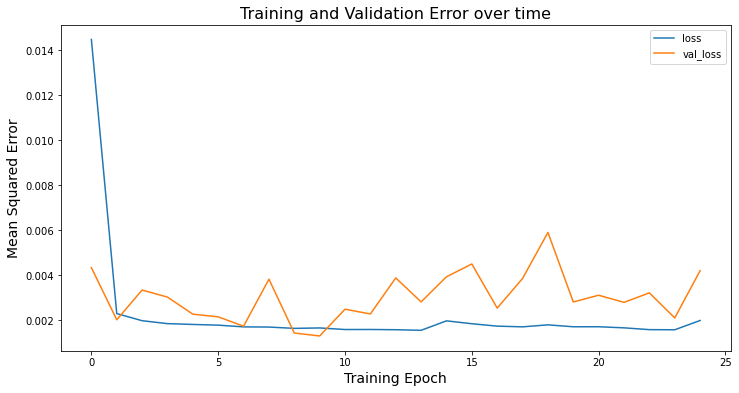

In [23]:
###### EVALUATION TRAINING with MSE as a Metrics ######
cm.training_evaluation(hist)

In [296]:
# Making Predictions
#predictions_energy_price = rnn.predict(X_test)

In [297]:
#predictions_energy_price = scaler.inverse_transform(predictions_energy_price)

In [341]:
############ Making the Prediction to dataFrame and putting it together with the test data ###############
#pred = pd.DataFrame(predictions_energy_price, columns=["Prediction"])
#pred.index = test_set.index
#test_pred_concat = pd.concat([test_set, pred], axis=1)
#test_pred_concat

,RRP5min,Prediction
SETTLEMENTDATE,,
2010-01-01 00:00:00,1.667928,1.554268
2010-01-01 00:05:00,1.742618,1.526216
2010-01-01 00:10:00,1.729679,1.552132
2010-01-01 00:15:00,1.746808,1.473067
2010-01-01 00:20:00,1.655297,1.505982
...,...,...
2010-06-29 03:50:00,1.606734,1.439598
2010-06-29 03:55:00,1.575924,1.438354
2010-06-29 04:00:00,1.600646,1.417876


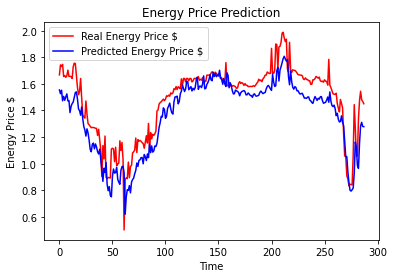

In [303]:
# Visualising the Results
plt.plot(test_set[0:288], color='red', label='Real Energy Price $')
plt.plot(predictions_energy_price[0:288], color='blue', label='Predicted Energy Price $')
plt.title('Energy Price Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Price $')
plt.legend()

In [352]:
# Model Evaluation Metrics
print('MAE: ', mean_absolute_error(y_pred=results["Prediction"], y_true=results["RRP5min"]))

MAE:  0.1637320337881685


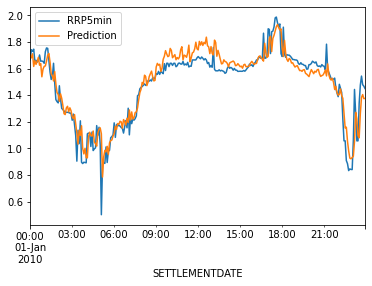

In [355]:
results['2010-01-01'].plot()

In [27]:
scaler.transform(test_set)

array([[0.42168764],
       [0.42982787],
       [0.42841767],
       ...,
       [0.41435473],
       [0.41169273],
       [0.37424421]])

In [26]:
X_test

array([[[0.42830314],
        [0.43567692],
        [0.43363577],
        ...,
        [0.44413684],
        [0.43547166],
        [0.42610106]],

       [[0.43567692],
        [0.43363577],
        [0.43229605],
        ...,
        [0.43547166],
        [0.42610106],
        [0.42168764]],

       [[0.43363577],
        [0.43229605],
        [0.43174994],
        ...,
        [0.42610106],
        [0.42168764],
        [0.42982787]],

       ...,

       [[0.42141226],
        [0.42046898],
        [0.42049232],
        ...,
        [0.41365413],
        [0.41501828],
        [0.41166039]],

       [[0.42046898],
        [0.42049232],
        [0.42105824],
        ...,
        [0.41501828],
        [0.41166039],
        [0.41435473]],

       [[0.42049232],
        [0.42105824],
        [0.41978346],
        ...,
        [0.41166039],
        [0.41435473],
        [0.41169273]]])

In [ ]:
#############
## since we want to predict all 5 mins interval over the course of the day at once
# We must split the data in chunck of 288 5 mins interbvals each
# to represent a full day
# N * 288 * 1
# Labels must bbe of shape N * 288

In [140]:
# Scale the data first
train = dataSA.copy()
train["RRP5min"] = scaler.fit_transform(dataSA["RRP5min"].values.reshape(-1,1))
train = train[:"2010-06-28"]

In [141]:
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 288
for i in range(1,lags+1):
    train["l_{}".format(i)] = train["RRP5min"].shift(i)

In [142]:
# Drop NANS
train.dropna(inplace=True)
train.tail(5)

,RRP5min,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_279,l_280,l_281,l_282,l_283,l_284,l_285,l_286,l_287,l_288
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2010-06-28 23:35:00,0.600496,0.500817,0.453280,0.512191,0.564050,0.583164,0.582286,0.537876,0.502329,0.531878,...,0.487336,0.509557,0.509557,0.509557,0.475000,0.494206,0.509557,0.533699,0.536350,0.562508
2010-06-28 23:40:00,0.550022,0.600496,0.500817,0.453280,0.512191,0.564050,0.583164,0.582286,0.537876,0.502329,...,0.498073,0.487336,0.509557,0.509557,0.509557,0.475000,0.494206,0.509557,0.533699,0.536350
2010-06-28 23:45:00,0.545530,0.550022,0.600496,0.500817,0.453280,0.512191,0.564050,0.583164,0.582286,0.537876,...,0.463196,0.498073,0.487336,0.509557,0.509557,0.509557,0.475000,0.494206,0.509557,0.533699
2010-06-28 23:50:00,0.510218,0.545530,0.550022,0.600496,0.500817,0.453280,0.512191,0.564050,0.583164,0.582286,...,0.468621,0.463196,0.498073,0.487336,0.509557,0.509557,0.509557,0.475000,0.494206,0.509557
2010-06-28 23:55:00,0.510035,0.510218,0.545530,0.550022,0.600496,0.500817,0.453280,0.512191,0.564050,0.583164,...,0.462995,0.468621,0.463196,0.498073,0.487336,0.509557,0.509557,0.509557,0.475000,0.494206


In [143]:
# create feature and label dataframes
prelim_features = train.drop('RRP5min', axis=1)
prelim_labels = pd.DataFrame(train['RRP5min'])

In [144]:
# format labels to 24 hour output range
for i in range(0, 288):
    prelim_labels['t_{}'.format(i)] = prelim_labels['RRP5min'].shift(-i)
prelim_labels.drop('RRP5min', axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.minute == 0]
labels = labels[labels.index.hour == 0]
features = prelim_features[prelim_features.index.minute == 0]
features = features[features.index.hour == 0]

features_train = features[:'2009']
features_test = features['2010':]
labels_train = labels[:'2009']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 288

# convert pandas data frames to numpy ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

# check for correct data shape
features_train.shape, labels_train.shape

((548, 288, 1), (548, 288))

In [145]:
features_test.shape

(143, 288, 1)

In [146]:
X_test = dataSA["2010-01-01":"2010-06-28"]

In [148]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [152]:
# train the model and calculate the performance on the test set
results, hist = train_predict_evaluate(rnn, X_train, X_valid, y_train, y_valid, features_test,
                                       X_test.to_numpy().flatten(), X_test.index, scaler, 32, 25, 
                                       'simple_neural_network.hdf5', verbose=1)

Epoch 1/25
14/14 [==============================] - 1s 46ms/step - loss: 0.2825 - val_loss: 0.2789
Epoch 2/25
14/14 [==============================] - 0s 19ms/step - loss: 0.2684 - val_loss: 0.2650
Epoch 3/25
14/14 [==============================] - 0s 17ms/step - loss: 0.2547 - val_loss: 0.2516
Epoch 4/25
14/14 [==============================] - 0s 14ms/step - loss: 0.2417 - val_loss: 0.2387
Epoch 5/25
14/14 [==============================] - 0s 14ms/step - loss: 0.2292 - val_loss: 0.2264
Epoch 6/25
14/14 [==============================] - 0s 18ms/step - loss: 0.2171 - val_loss: 0.2146
Epoch 7/25
14/14 [==============================] - 0s 18ms/step - loss: 0.2057 - val_loss: 0.2033
Epoch 8/25
14/14 [==============================] - 0s 17ms/step - loss: 0.1948 - val_loss: 0.1926
Epoch 9/25
14/14 [==============================] - 0s 13ms/step - loss: 0.1843 - val_loss: 0.1823
Epoch 10/25
14/14 [==============================] - 0s 18ms/step - loss: 0.1743 - val_loss: 0.1725
Epoch 11/

In [151]:
def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, X_test, y_test, test_index, scaler, 
                           batch_size, epochs, filename='model.hdf5', verbose=0):
    
    """Fit model to training data. Use best performant on validation data to predict for the test set. 
    Evaluate on the test set and return results as dataframes"""
    
    # train model, save best keep best performer on validation set
    checkpoint = ModelCheckpoint('./models/' + filename, save_best_only=True)
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[checkpoint], 
                     verbose=verbose, batch_size=batch_size, epochs=epochs)
    
    # load best model
    best = load_model('./models/' + filename)

    # predict for test set
    pred = best.predict(X_test)
    
    
    # transform back to original data scale
    pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))
    results = pd.DataFrame({'prediction':pred.flatten(), 'true values':y_test}, index=test_index)
    
    return results, hist

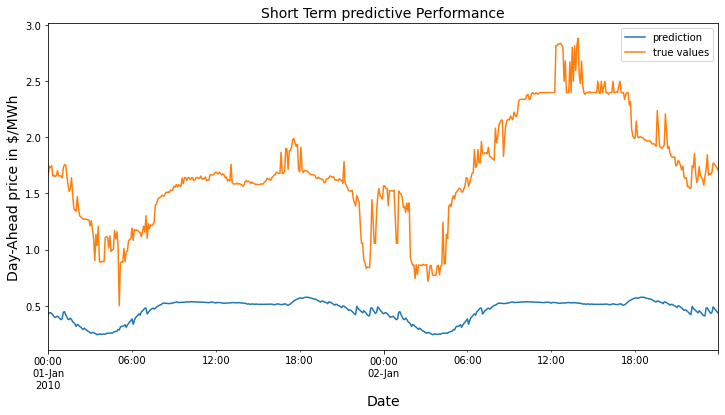

In [155]:
f, ax = plt.subplots(figsize=(12, 6))
results.loc['2010-01-01':'2010-01-2'].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in $/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Short Term predictive Performance', fontsize=14);

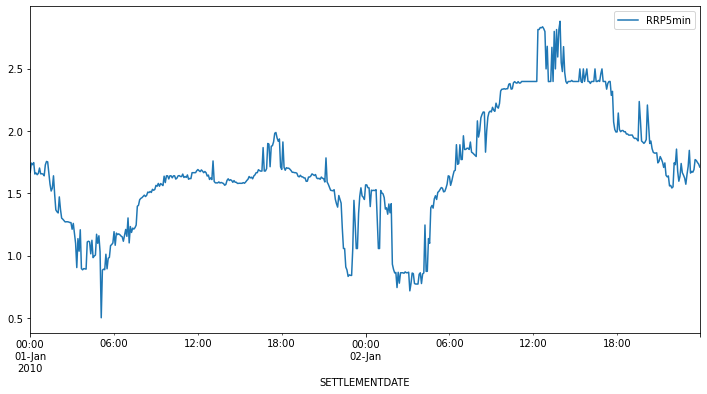

In [156]:
f, ax = plt.subplots(figsize=(12, 6))
dataSA.loc['2010-01-01':'2010-01-2'].plot(ax=ax);

In [169]:
results[results["prediction"] > 0.5]

,prediction,true values
SETTLEMENTDATE,,
2010-01-01 07:55:00,0.504023,1.459672
2010-01-01 08:00:00,0.508310,1.465616
2010-01-01 08:05:00,0.511497,1.475763
2010-01-01 08:10:00,0.521473,1.485672
2010-01-01 08:15:00,0.524880,1.474487
...,...,...
2010-06-28 20:35:00,0.514663,4.064184
2010-06-28 20:40:00,0.512891,3.310660
2010-06-28 20:45:00,0.504569,3.277074


In [160]:
scaler.inverse_transform(results["prediction"].flatten().reshape(-1, 1))

AttributeError: 'Series' object has no attribute 'flatten'

In [167]:
features_test

array([[[0.42610106],
        [0.43547166],
        [0.44413684],
        ...,
        [0.43363577],
        [0.43567692],
        [0.42830314]],

       [[0.39804358],
        [0.39998263],
        [0.4011853 ],
        ...,
        [0.42841767],
        [0.42982787],
        [0.42168764]],

       [[0.41913571],
        [0.42145931],
        [0.43114588],
        ...,
        [0.39763978],
        [0.39617836],
        [0.38617228]],

       ...,

       [[0.51219086],
        [0.562509  ],
        [0.56250645],
        ...,
        [0.49546465],
        [0.4846695 ],
        [0.4699471 ]],

       [[0.57113503],
        [0.5835767 ],
        [0.58733375],
        ...,
        [0.56477828],
        [0.56477828],
        [0.50060946]],

       [[0.49420649],
        [0.50955701],
        [0.53369869],
        ...,
        [0.59702695],
        [0.57070526],
        [0.57158996]]])

In [166]:
scaler.inverse_transform(x.flatten().reshape(-1,1))

array([[0.43015328],
       [0.4388927 ],
       [0.440386  ],
       ...,
       [0.46454766],
       [0.4532146 ],
       [0.43864605]], dtype=float32)